# Hazelcast HW
https://github.com/maxmyk/software_architecture_HW2


## 1. Встановити і налаштувати Hazelcast

## 2. Сконфігурувати і запустити 3 ноди (інстанси) об'єднані в кластер або як частину Java-застосування, або як окремі застосування

I've done it using three Docker instances.
```
docker run -it --name first-hazelcast-node  --rm -e HZ_NETWORK_PUBLICADDRESS=172.17.0.1:5701 -e HZ_CLUSTERNAME=hazelcast-cluster -p 5701:5701 hazelcast/hazelcast:5.3.6
docker run -it --name second-hazelcast-node --rm -e HZ_NETWORK_PUBLICADDRESS=172.17.0.1:5702 -e HZ_CLUSTERNAME=hazelcast-cluster -p 5702:5701 hazelcast/hazelcast:5.3.6
docker run -it --name third-hazelcast-node  --rm -e HZ_NETWORK_PUBLICADDRESS=172.17.0.1:5703 -e HZ_CLUSTERNAME=hazelcast-cluster -p 5703:5701 hazelcast/hazelcast:5.3.6
```

you can run them simultaneously using ```run.sh```

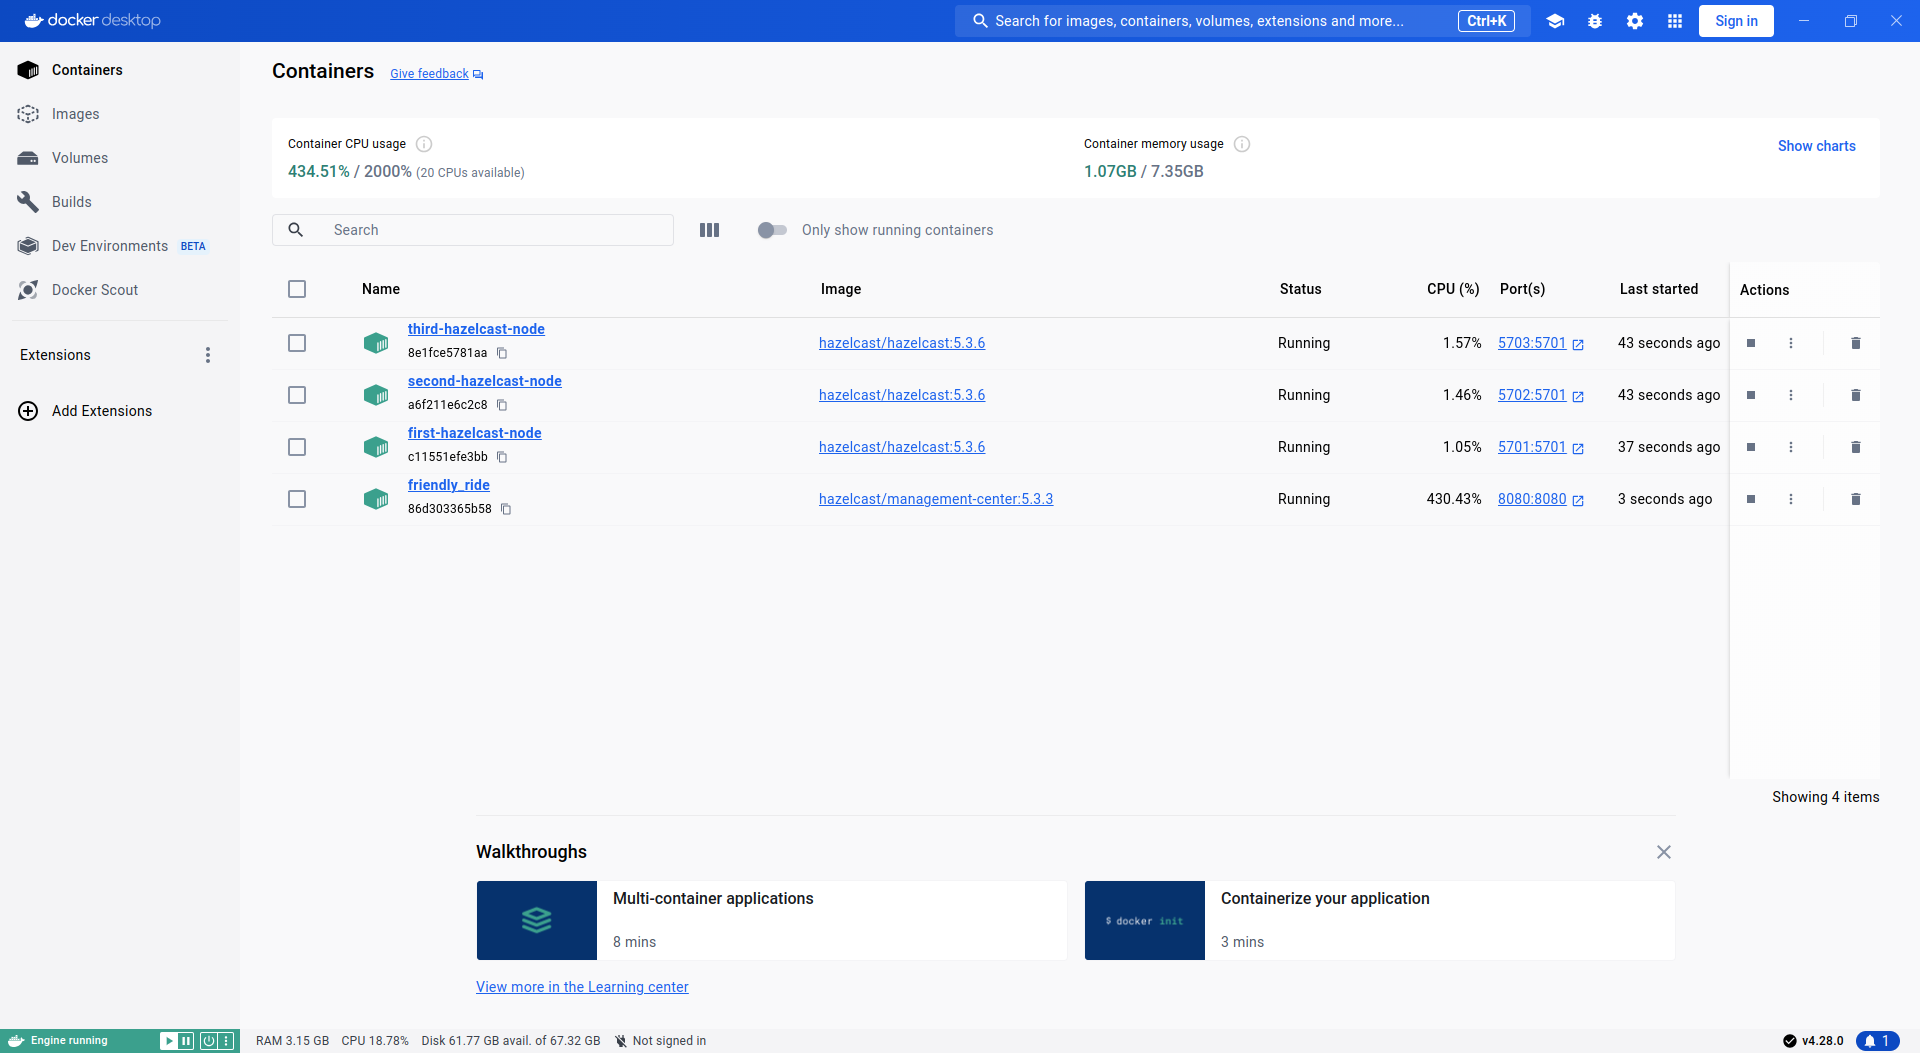

## 3. Продемонструйте роботу Distributed Map

### Використовуючи API створіть Distributed Map + запишіть в неї 1000 значень з ключем від 0 до 1к

In [1]:
import hazelcast
from tqdm import tqdm

client = hazelcast.HazelcastClient(
    cluster_name="hazelcast-cluster",
    cluster_members=[
        "172.17.0.1:5701",
        "172.17.0.1:5702",
        "172.17.0.1:5703",
    ],
    lifecycle_listeners=[
        lambda state: print(">>>", state),
    ]
)
# Step 1: Create a Distributed Map
distributed_map = client.get_map("my-distributed-map").blocking()

# Step 2: Write 1000 values to the Distributed Map
for i in tqdm(range(1000)):
    distributed_map.put(i, f"value-{i}")

client.shutdown()

>>> STARTING
>>> STARTED
>>> CONNECTED


100%|██████████| 1000/1000 [00:00<00:00, 2930.69it/s]

>>> SHUTTING_DOWN
>>> DISCONNECTED
>>> SHUTDOWN


### За допомогою Management Center подивиться на розподіл значень по нодах

![dm.png](images/dm.png)

### Як зміниться розподіл даних по нодах

- якщо відключити одну ноду

Дані перерозподіляться.
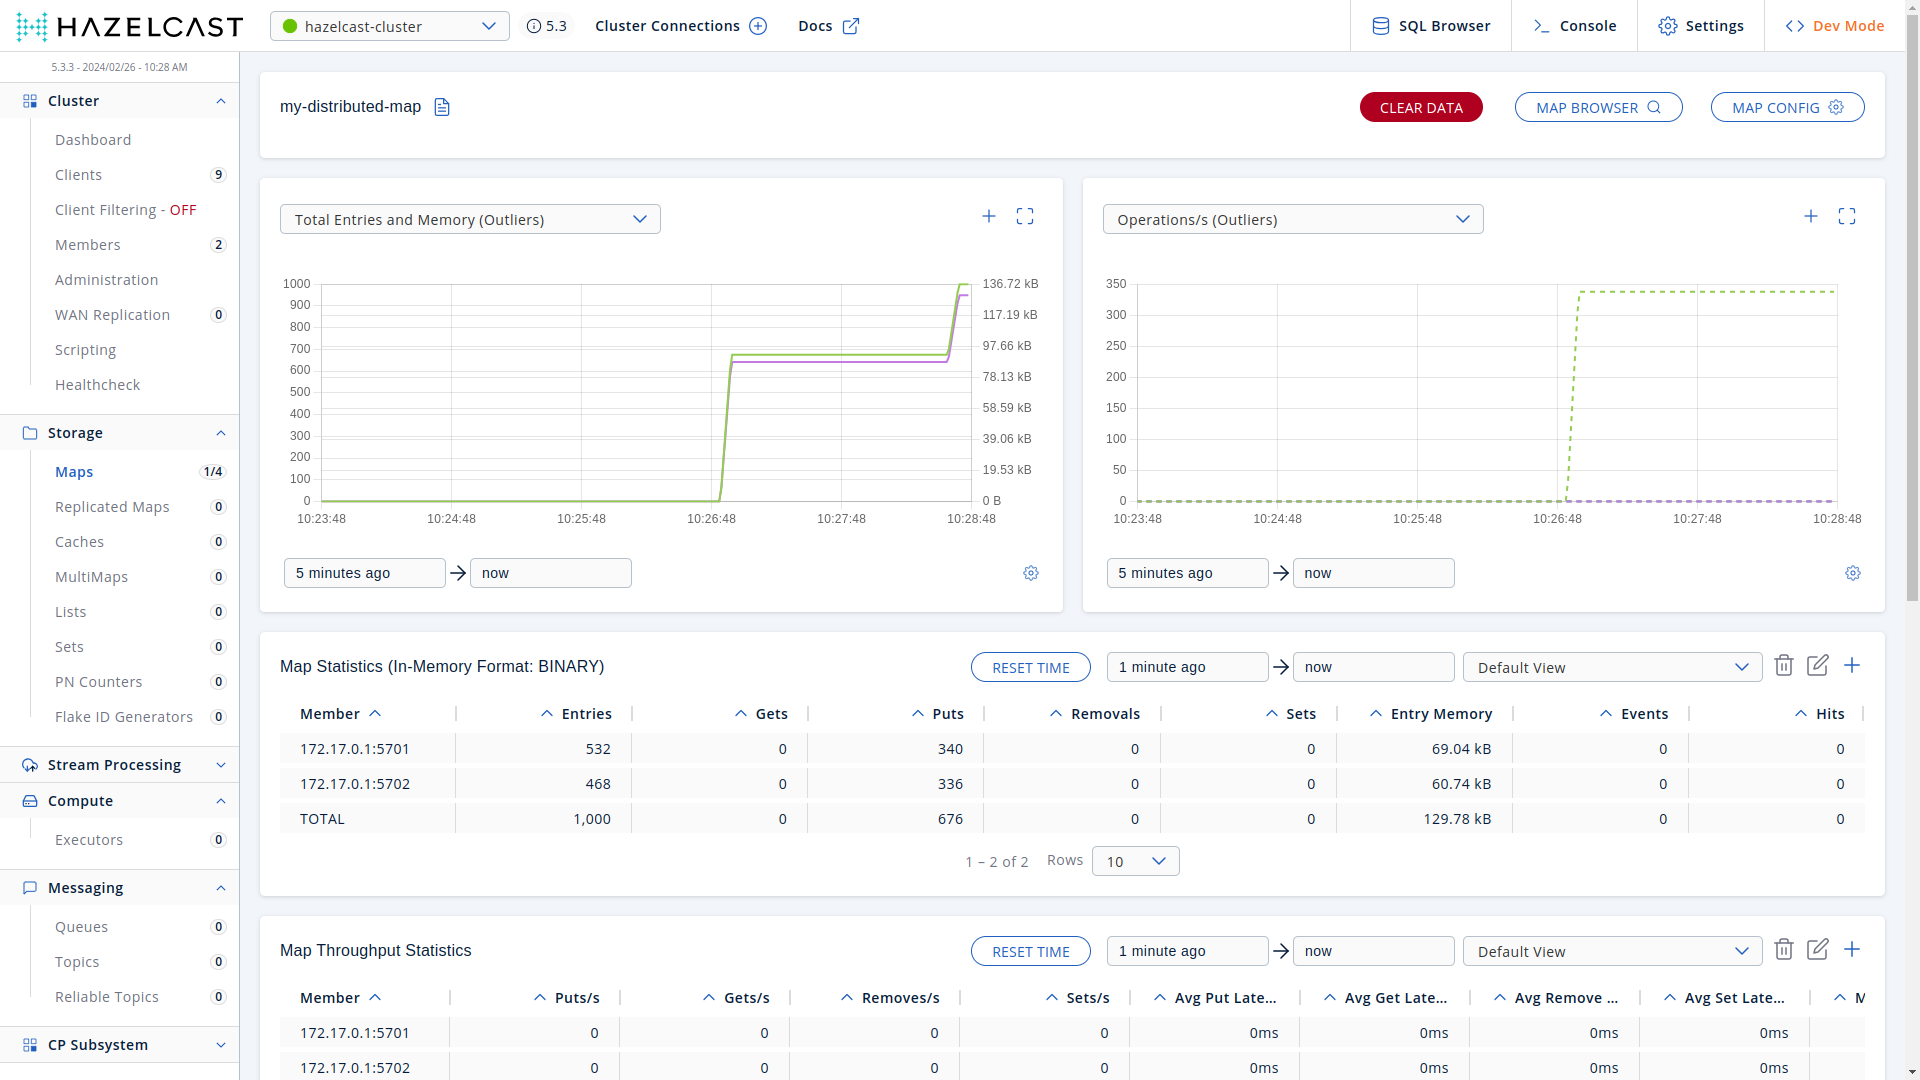

- відключити дві ноди.

Якщо зробити це по черзі, то дані збережуться, якщо одночасно, то частина даних втратиться.
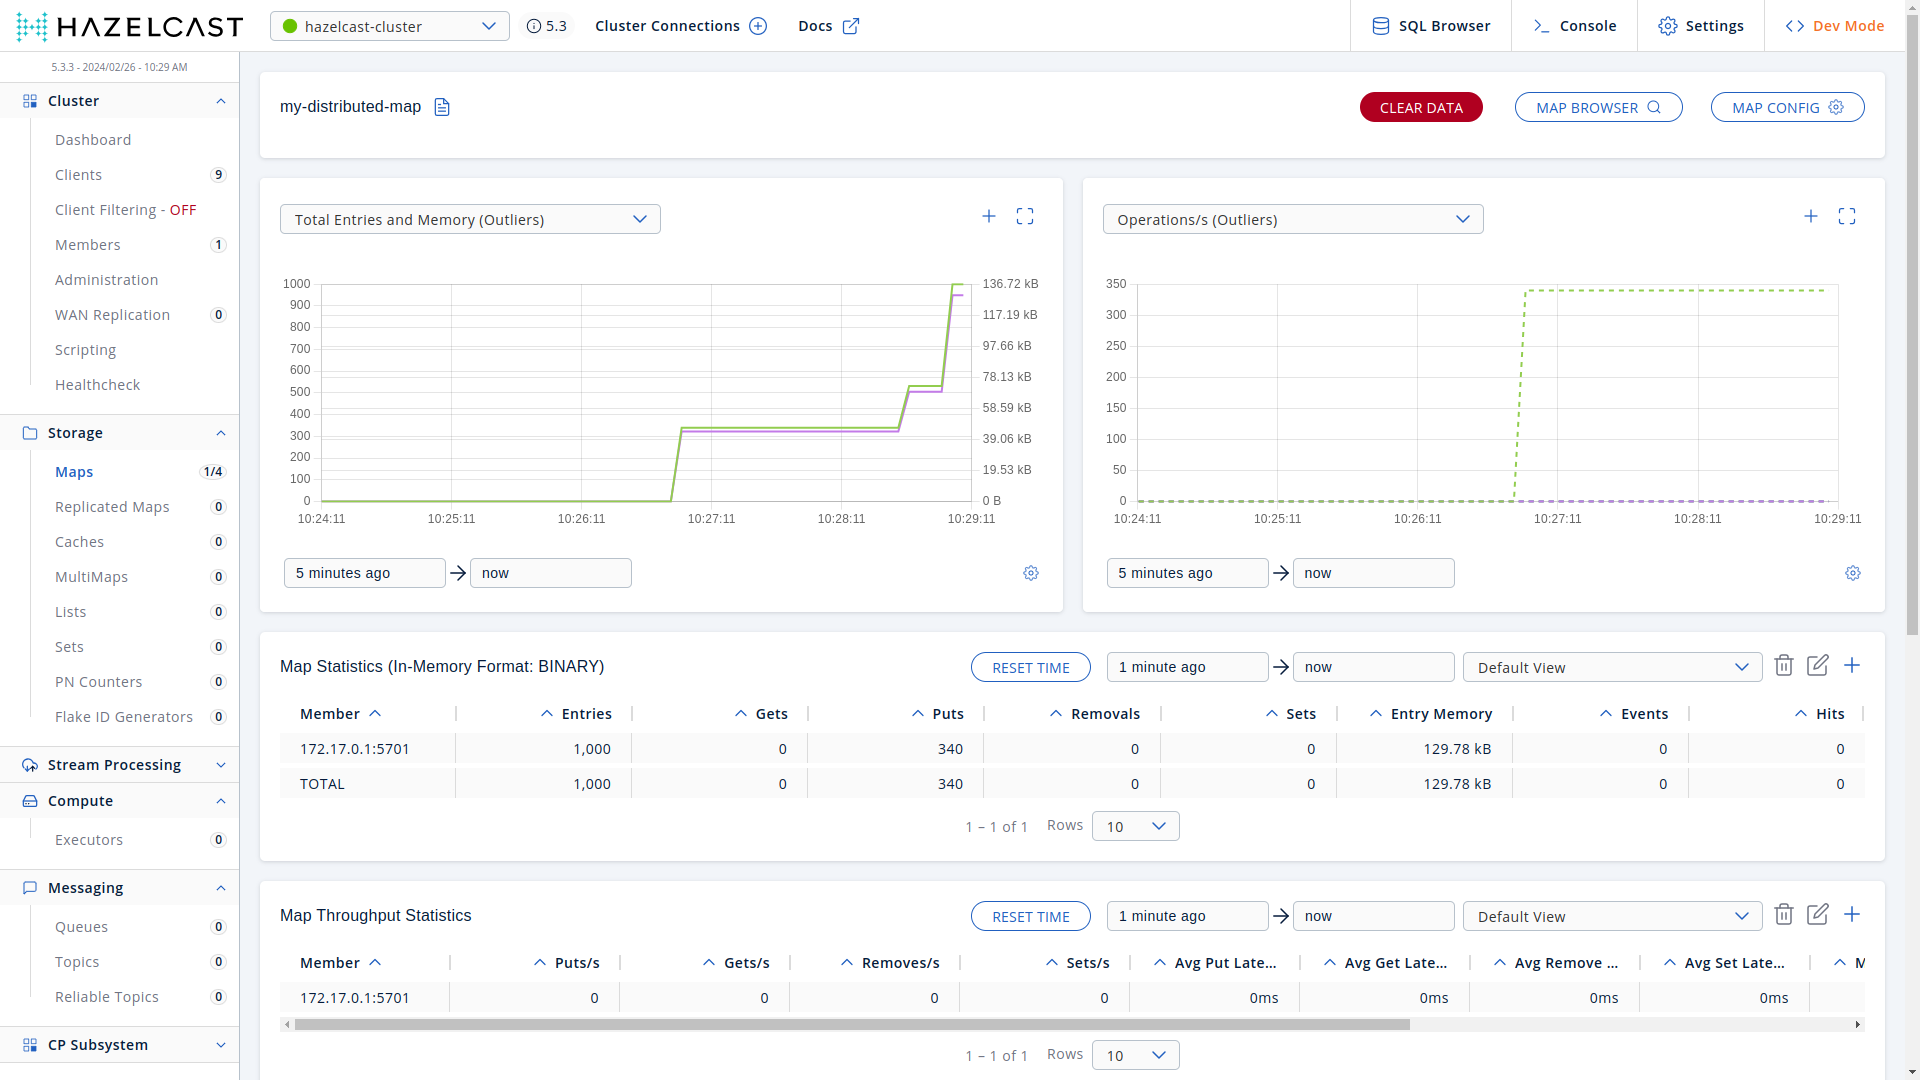
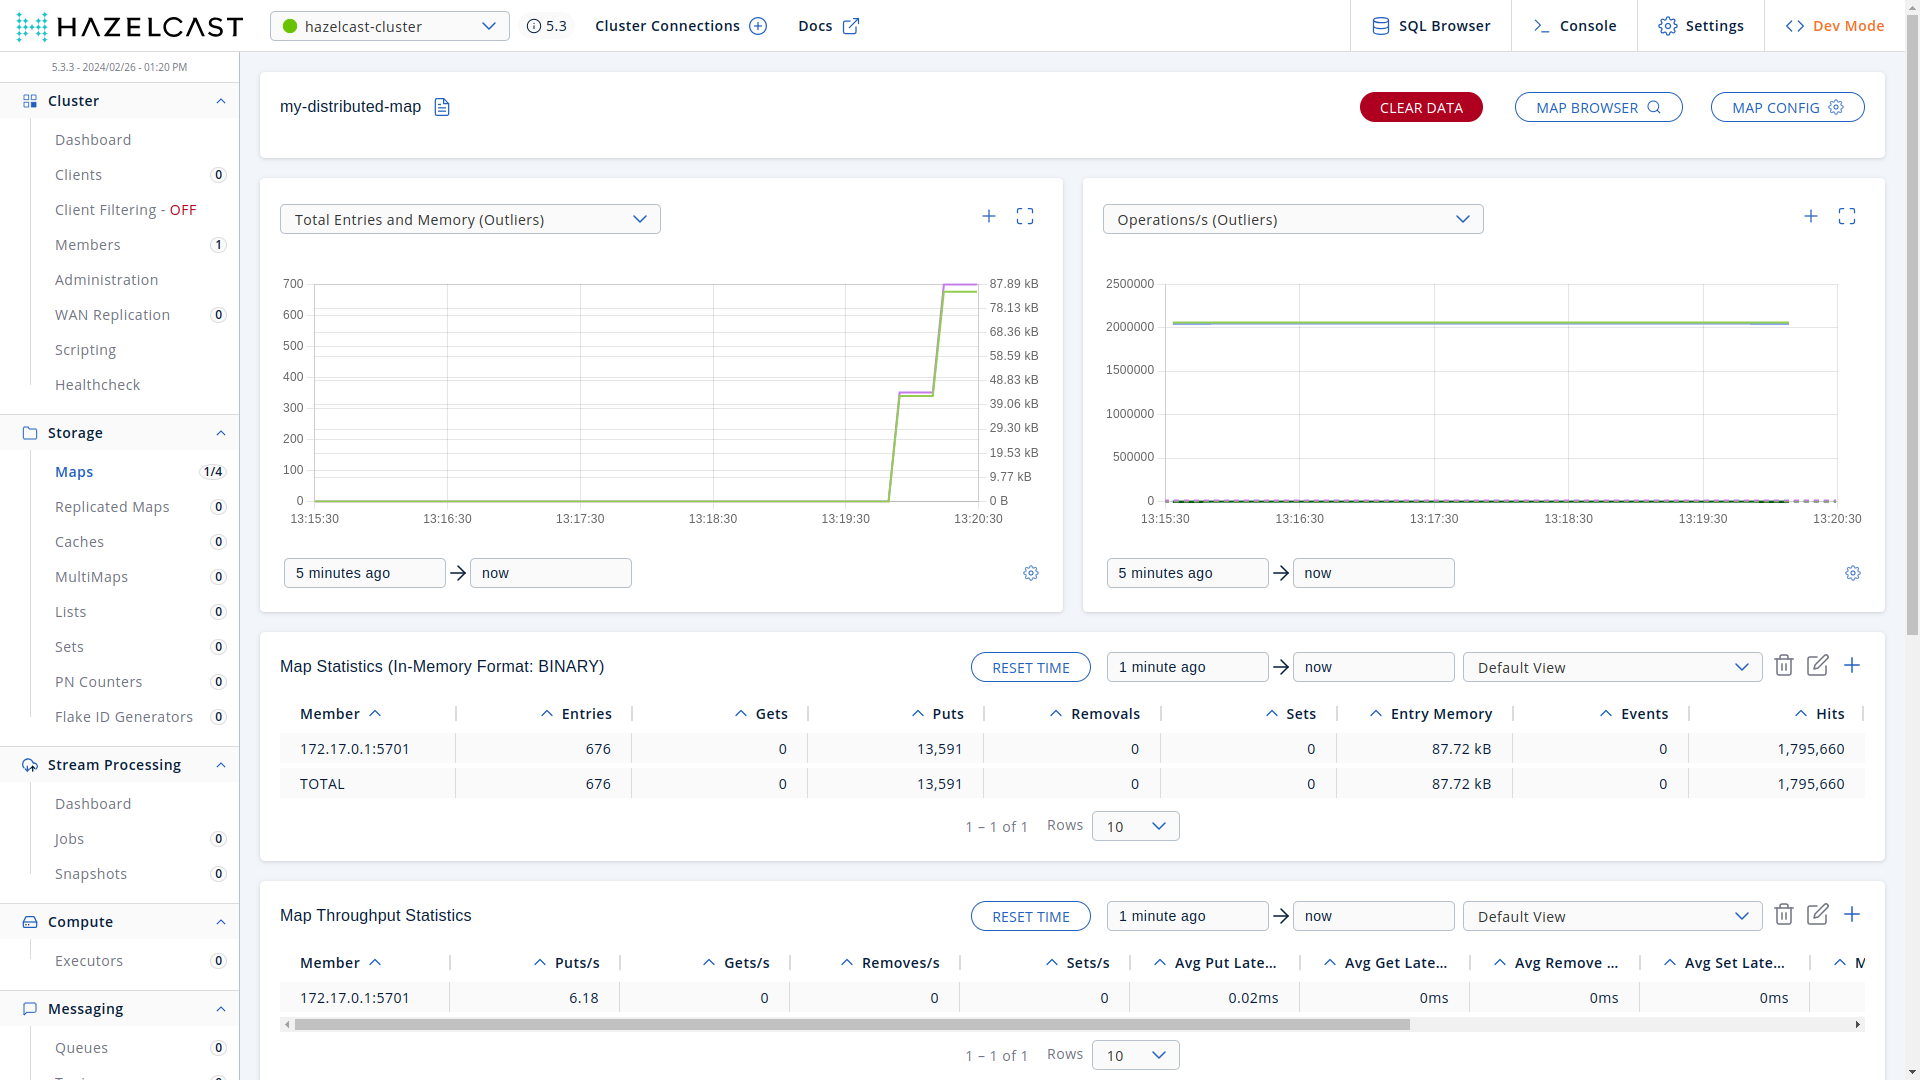

- Чи буде втрата даних?

Якщо багато вузлів відключаться одночасно, не буде з чого відновити дані.

- Яким чином зробити щоб не було втрати даних?

Щоб уникнути втрати даних, треба, щоб кластер мав достатню кількість резервних вузлів.
Це гарантує, що навіть якщо один або декілька вузлів вийде з ладу, дані все одно можна буде відновити з резервних.

## 4. Продемонструйте роботу Distributed Map with locks

In [2]:
# helpers for testing the locking

import multiprocessing
from hazelcast import HazelcastClient
from tqdm import tqdm

verbose = False

# =============================================================================

def increment_value():
    client = HazelcastClient(
        cluster_name="hazelcast-cluster",
        cluster_members=[
            "172.17.0.1:5701",
            "172.17.0.1:5702",
            "172.17.0.1:5703",
        ],
        lifecycle_listeners=[
            lambda state: print(">>>", state) if verbose else None,
        ]
    )
    map = client.get_map("my-distributed-map").blocking()

    for _ in tqdm(range(10000), disable=(not verbose)):
        value = map.get("key")
        value += 1
        map.put("key", value)
    if verbose:
        print(map.get("key"))
    return map.get("key").__str__()

def increment_value_pl(): # pl = pesimistic lock
    client = HazelcastClient(
        cluster_name="hazelcast-cluster",
        cluster_members=[
            "172.17.0.1:5701",
            "172.17.0.1:5702",
            "172.17.0.1:5703",
        ],
        lifecycle_listeners=[
            lambda state: print(">>>", state) if verbose else None,
        ]
    )
    map = client.get_map("my-distributed-map").blocking()
    last_value = 0
    for _ in tqdm(range(10000), disable=(not verbose)):
        map.lock("key")
        try:
            value = map.get("key")
            value += 1
            map.put("key", value)
            last_value = value
        finally:
            map.unlock("key")
    if verbose:
        print(last_value)
    return last_value
    
def increment_value_ol(): # ol = optimistic lock
    client = HazelcastClient(
        cluster_name="hazelcast-cluster",
        cluster_members=[
            "172.17.0.1:5701",
            "172.17.0.1:5702",
            "172.17.0.1:5703",
        ],
        lifecycle_listeners=[
            lambda state: print(">>>", state) if verbose else None,
        ]
    )
    map = client.get_map("my-distributed-map").blocking()
    last_value = 0
    
    for _ in tqdm(range(10000), disable=(not verbose)):
        while True:
            value = map.get("key")
            value += 1
            last_value = value
            if map.replace_if_same("key", value - 1, value):
                break
    if verbose:
        print(last_value)
    return last_value

# =============================================================================

def test_func(func, num_prc=3):
    prc = []
    for _ in range(num_prc):
        p = multiprocessing.Process(target=func)
        p.start()
        prc.append(p)
    for p in prc:
        p.join()

def test_increment_value():
    test_func(increment_value)

def test_increment_value_pl():
    test_func(increment_value_pl)
    
def test_increment_value_ol():
    test_func(increment_value_ol)

In [3]:
client = hazelcast.HazelcastClient(
    cluster_name="hazelcast-cluster",
    cluster_members=[
        "172.17.0.1:5701",
        "172.17.0.1:5702",
        "172.17.0.1:5703",
    ],
    lifecycle_listeners=[
        lambda state: print(">>>", state),
    ]
)
def test_prep():
    client.get_map("my-distributed-map").blocking().clear()
    my_map = client.get_map("my-distributed-map")
    my_map.put_if_absent("key", 0)
    return my_map

my_map = test_prep()
test_increment_value()
print("Test 1, unlocked increment finished. Final key value:", my_map.get("key").result())

my_map = test_prep()
test_increment_value_pl()
print("Test 2, pessimistic locking increment finished. Final key value:", my_map.get("key").result())

my_map = test_prep()
test_increment_value_ol()
print("Test 3, optimistic locking increment finished. Final key value:", my_map.get("key").result())

client.shutdown()

>>> STARTING
>>> STARTED
>>> CONNECTED
Test 1, unlocked increment finished. Final key value: 11946
Test 2, pessimistic locking increment finished. Final key value: 30000
Test 3, optimistic locking increment finished. Final key value: 30000
>>> SHUTTING_DOWN
>>> DISCONNECTED
>>> SHUTDOWN


### Порівняйте результати кожного з запусків
В реалізації без блокувань спостерігається втрата даних, а у реалізаціях з песимістичним та оптимістичним блокуванням є однакові результати, як і очікувано.

```
Test 1, unlocked increment finished. Final key value: ~13000
Test 2, pessimistic locking increment finished. Final key value: 30000
Test 3, optimistic locking increment finished. Final key value: 30000
```

## 5. Робота з Bounded queue

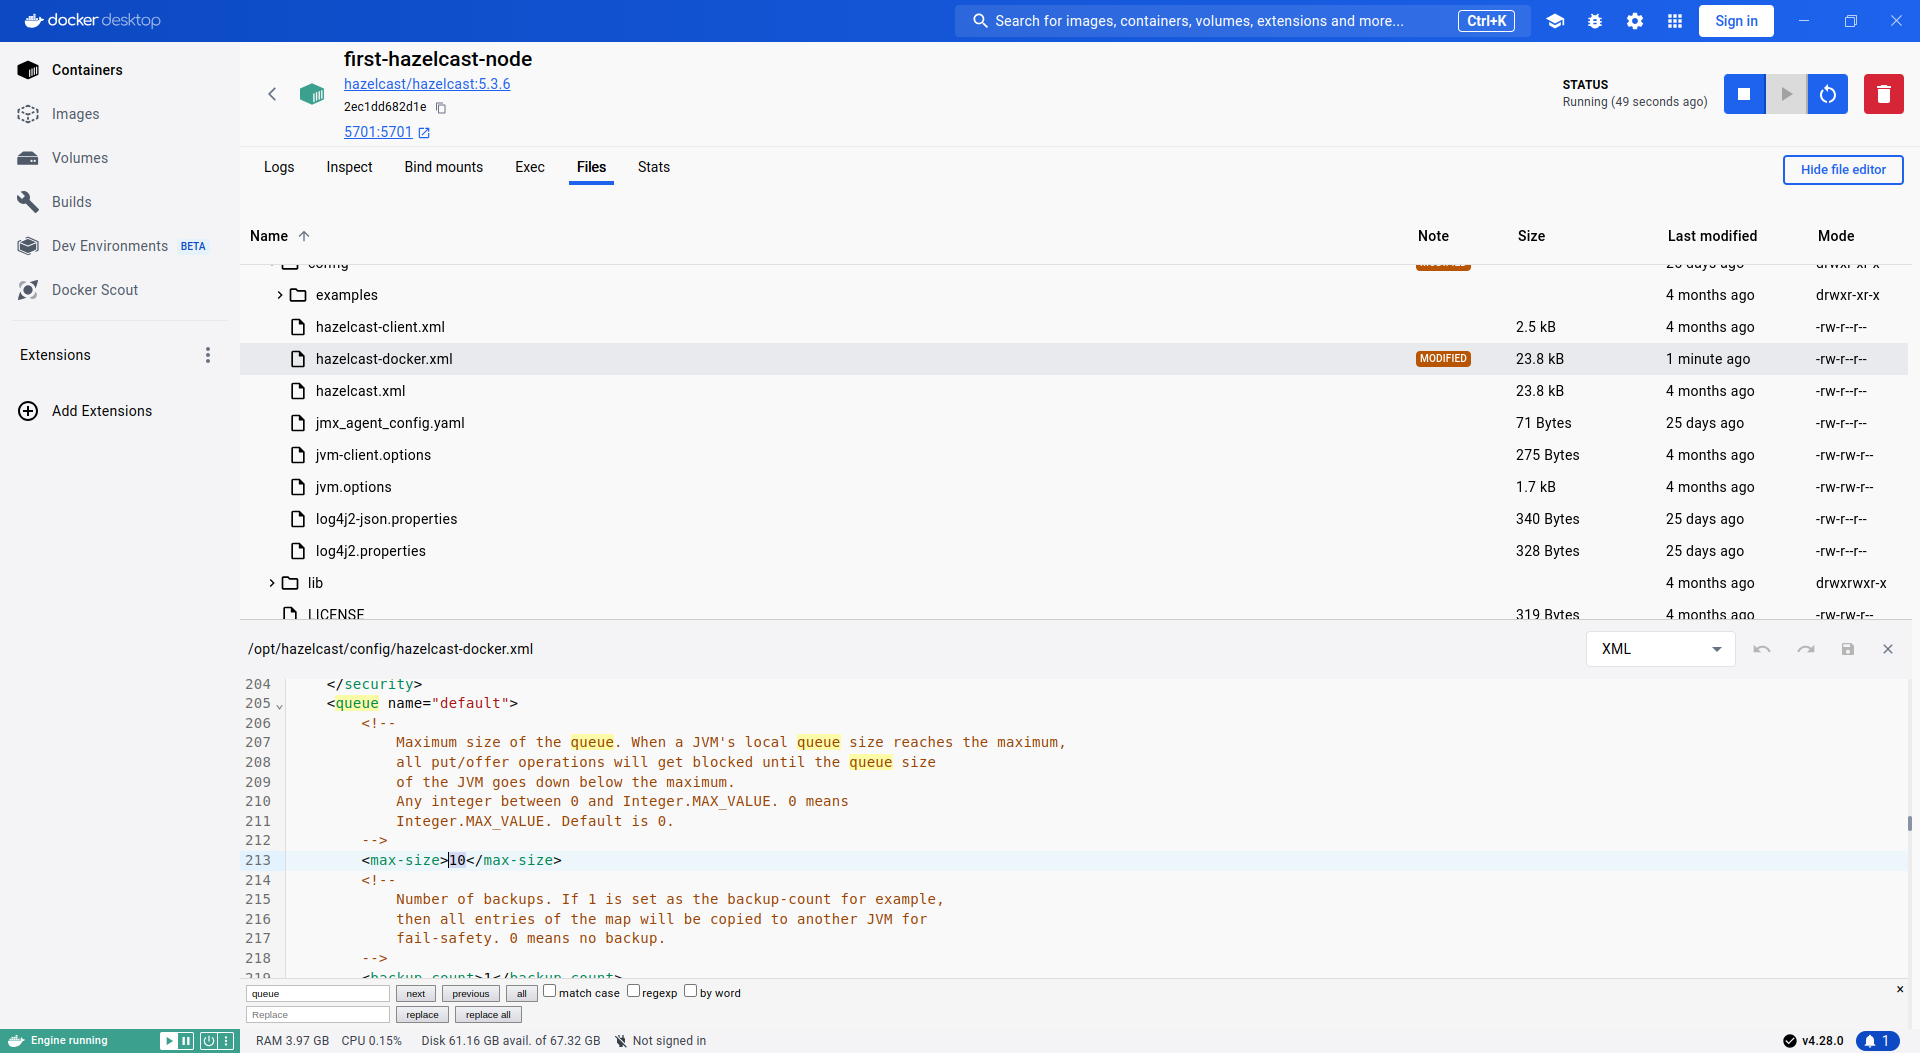

In [4]:
import hazelcast
import multiprocessing

def prod():
    client = hazelcast.HazelcastClient(cluster_name="hazelcast-cluster",
    cluster_members=[
        "172.17.0.1:5701",
    ],
    lifecycle_listeners=[
        lambda state: print("Prod >>>", state),
    ])
    queue = client.get_queue("queue") # does not work without blocking
    for i in range(100):
        print("Producing {}".format(i))
        if not queue.offer("value-" + str(i)).result():
            i-=1
    client.shutdown()
        
def cons():
    client = hazelcast.HazelcastClient(cluster_name="hazelcast-cluster",
    cluster_members=[
        "172.17.0.1:5701",
    ],
    lifecycle_listeners=[
        lambda state: print("Cons >>>", state),
    ])
    queue = client.get_queue("queue").blocking() # does not work without blocking
    consumed_count = 0
    while queue.size() > 0: 
        head = queue.take()
        print("Consuming {}".format(head))
        consumed_count += 1
    client.shutdown()

prc = []
p = multiprocessing.Process(target=prod)
p.start()
prc.append(p)

pc1 = multiprocessing.Process(target=cons)
pc1.start()
prc.append(pc1)

pc2 = multiprocessing.Process(target=cons)
pc2.start()
prc.append(pc2)

for p in prc:
    p.join()



Prod >>> STARTINGCons >>>
Prod >>>  STARTINGSTARTED

Cons >>> STARTEDCons >>>
 STARTING
Prod >>>Cons >>>  CONNECTEDCons >>>STARTED
 
CONNECTED
Cons >>> CONNECTED
Producing 0
Cons >>> Producing 1SHUTTING_DOWN

Cons >>>Producing 2
 DISCONNECTED
Producing 3
Consuming value-0Producing 4

Producing 5
Consuming value-1
Producing 6
Consuming value-2
Producing 7
Producing 8Consuming value-3

Cons >>>Producing 9 
Consuming value-4SHUTDOWN

Producing 10
Consuming value-5Producing 11

Producing 12
Consuming value-6
Producing 13
Consuming value-7Producing 14

Producing 15Consuming value-8

Producing 16Consuming value-9

Producing 17Consuming value-10

Producing 18Consuming value-11

Producing 19
Consuming value-12
Producing 20
Consuming value-13
Producing 21
Consuming value-14
Producing 22
Consuming value-15Producing 23

Producing 24Consuming value-16

Producing 25
Consuming value-17
Producing 26
Consuming value-18
Producing 27
Consuming value-19
Producing 28
Consuming value-20Producing 29

Produc

![image.png](images/queue.png)

Consumer 1 and Consumer 2 will concurrently consume items from the "queue," and Hazelcast will ensure that the load is distributed among them.

If there are no consumers, and the queue is full (with a maximum size of 10), attempting to write more items to the queue will block until space becomes available. Hazelcast will handle the blocking behavior internally.